In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


import os
import warnings
warnings.filterwarnings(action='once')

2024-06-13 13:36:04.987991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 13:36:04.988095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 13:36:05.116541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 128
NUM_EPOCHS = 25
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # No class labels, so we return 0 for all

In [6]:
dataset = CustomImageDataset(root_dir='/kaggle/input/anime-data/anime_dataset_reduced', transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [7]:
count = len(dataset)
count

8000

In [8]:
for i, (images, labels) in enumerate(data_loader):
    if i >= 2:
        break
    print(f"Batch {i+1}")
    print(images.shape)

Batch 1
torch.Size([64, 3, 64, 64])
Batch 2
torch.Size([64, 3, 64, 64])


## **Discriminator code**

In [9]:
class Discriminator(nn.Module):
    def __init__(self,img_channels,base_features):
        super(Discriminator,self).__init__()
        
        self.disc = nn.Sequential(
                        nn.Conv2d(img_channels,base_features,kernel_size=4,stride=2,padding=1),
                        nn.LeakyReLU(0.2),
                        self.block(in_channels=base_features,out_channels=base_features*2,kernel_size=4,stride=2,padding=1),
                        self.block(in_channels=base_features*2,out_channels=base_features*4,kernel_size=4,stride=2,padding=1),
                        self.block(in_channels=base_features*4,out_channels=base_features*8,kernel_size=4,stride=2,padding=1),
                        nn.Conv2d(in_channels=base_features*8,out_channels=1,kernel_size=4,stride=2,padding=0),
        )
        
        
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.LeakyReLU(0.2)
        )
    

    def forward(self, x):
        return self.disc(x)

## **Generator code**

In [10]:
class Generator(nn.Module):
    def __init__(self,noise_channels,img_channels,base_features):
        super(Generator,self).__init__()
        
        self.gen = nn.Sequential(
                    self.block(in_channels=noise_channels, out_channels=base_features * 16, kernel_size=4, stride=1, padding=0),  #  4x4
                    self.block(in_channels=base_features * 16, out_channels=base_features * 8, kernel_size=4, stride=2, padding=1),  # 8x8
                    self.block(in_channels=base_features * 8, out_channels=base_features * 4, kernel_size=4, stride=2, padding=1),  # 16x16
                    self.block(in_channels=base_features * 4, out_channels=base_features * 2, kernel_size=4, stride=2, padding=1),  # 32x32
                    nn.ConvTranspose2d(in_channels=base_features * 2, out_channels=img_channels, kernel_size=4, stride=2, padding=1),  # N x img_channels x 64 x 64
                    nn.Tanh(),
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.gen(x)

In [11]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [12]:
def plot_generated_images(generator, epoch, noise):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(noise).cpu()
    generator.train()
    img_grid = make_grid(fake_images, normalize=True)
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.show()

In [13]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [14]:
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

In [15]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


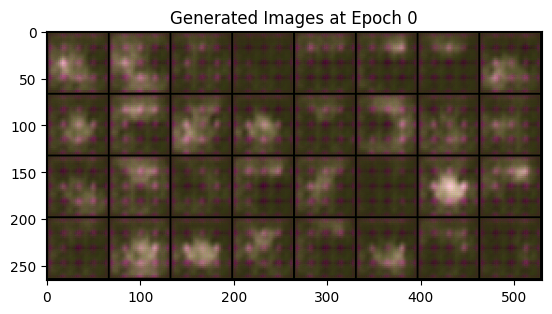

Epoch [1/25]  Loss D: -1.3732, loss G: 0.6384


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


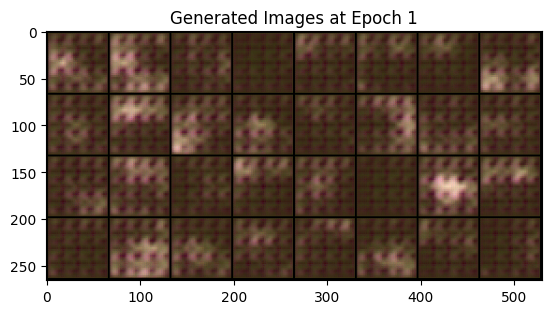

Epoch [2/25]  Loss D: -1.4755, loss G: 0.6892


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


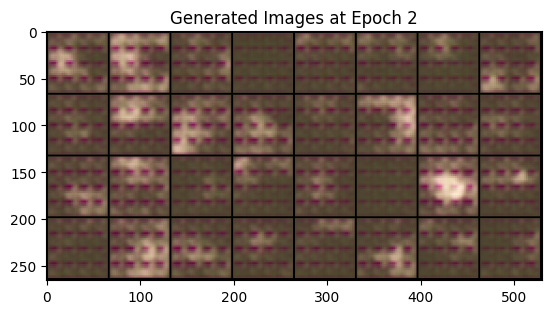

Epoch [3/25]  Loss D: -1.4867, loss G: 0.6924


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


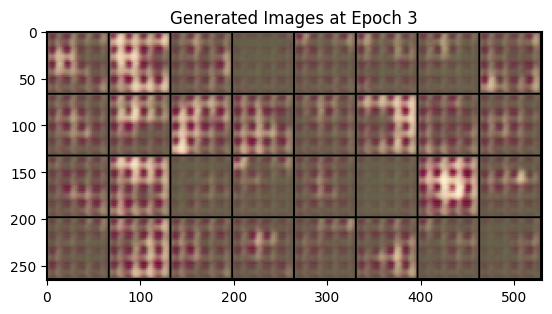

Epoch [4/25]  Loss D: -1.4838, loss G: 0.6925


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


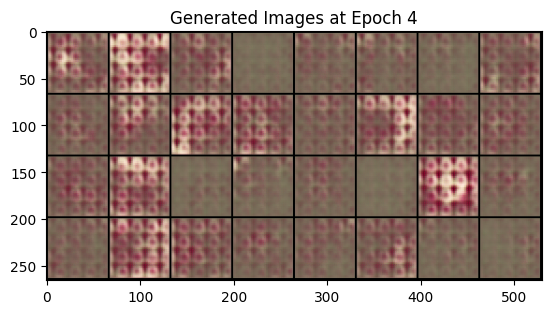

Epoch [5/25]  Loss D: -1.4824, loss G: 0.6918


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


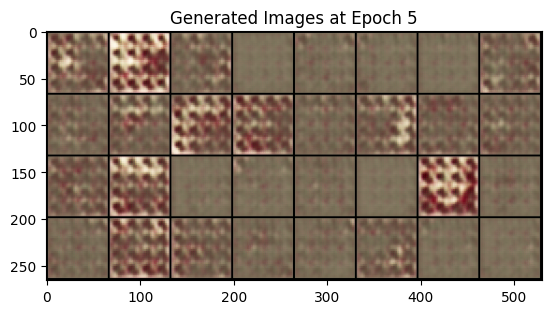

Epoch [6/25]  Loss D: -1.4841, loss G: 0.6927


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


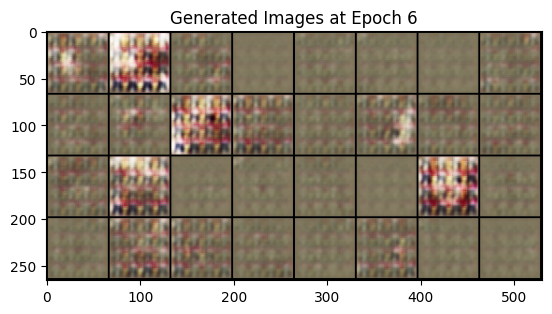

Epoch [7/25]  Loss D: -1.4795, loss G: 0.6929


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


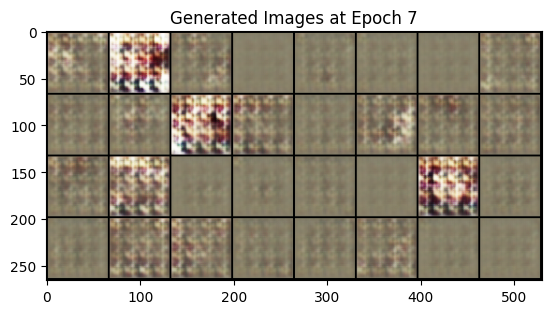

Epoch [8/25]  Loss D: -1.4786, loss G: 0.6911


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


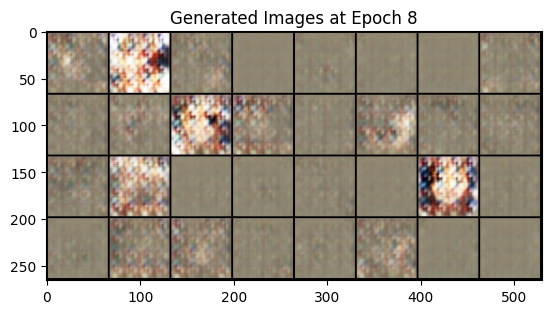

Epoch [9/25]  Loss D: -1.4733, loss G: 0.6897


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


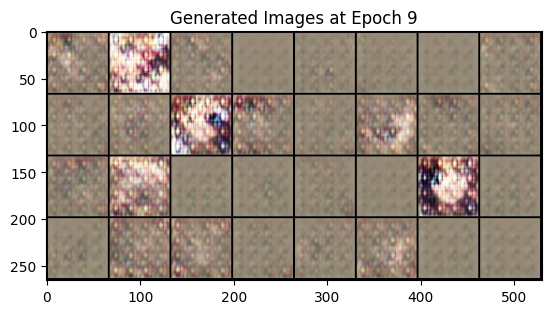

Epoch [10/25]  Loss D: -1.4804, loss G: 0.6907


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


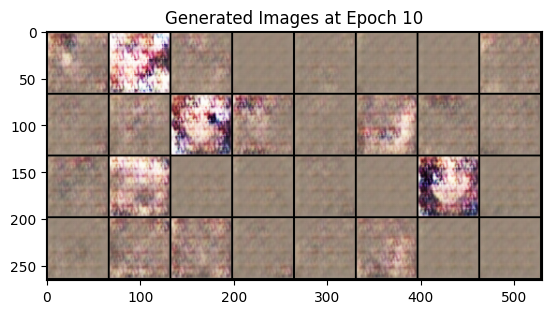

Epoch [11/25]  Loss D: -1.4716, loss G: 0.6902


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


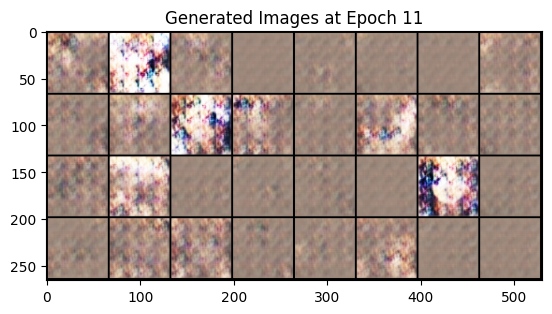

Epoch [12/25]  Loss D: -1.4747, loss G: 0.6889


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


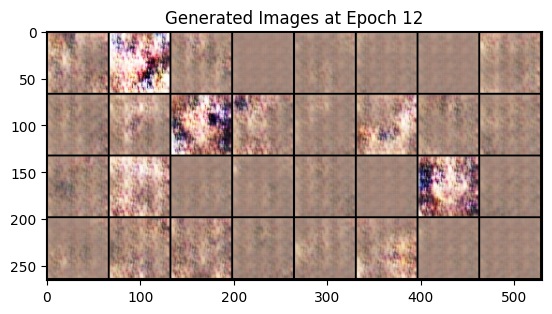

Epoch [13/25]  Loss D: -1.4720, loss G: 0.6896


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


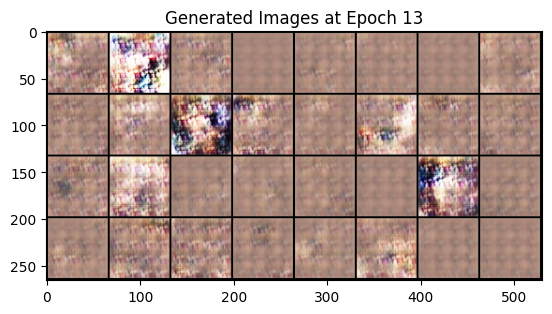

Epoch [14/25]  Loss D: -1.4695, loss G: 0.6887


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


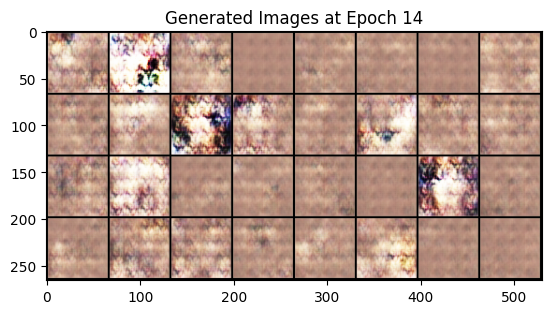

Epoch [15/25]  Loss D: -1.4721, loss G: 0.6883


100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


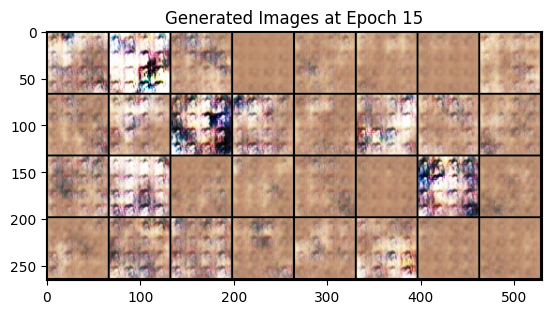

Epoch [16/25]  Loss D: -1.4724, loss G: 0.6883


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


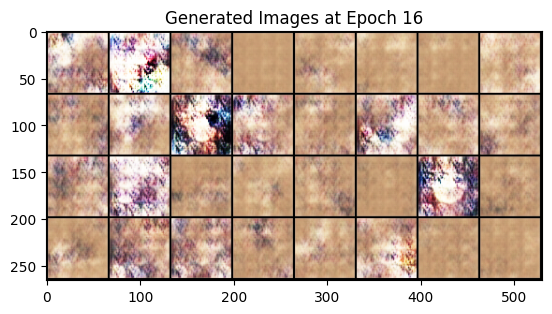

Epoch [17/25]  Loss D: -1.4654, loss G: 0.6872


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


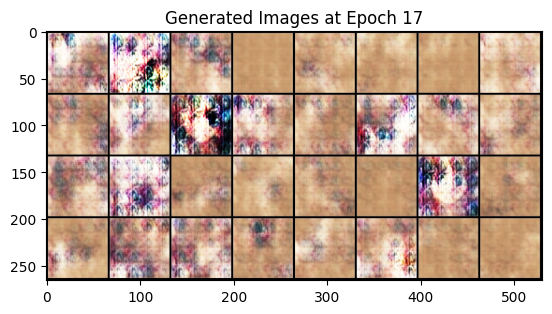

Epoch [18/25]  Loss D: -1.4701, loss G: 0.6882


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


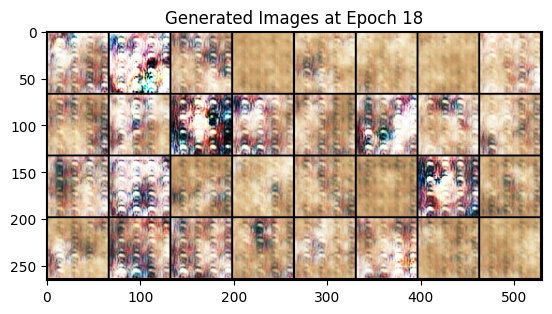

Epoch [19/25]  Loss D: -1.4645, loss G: 0.6849


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


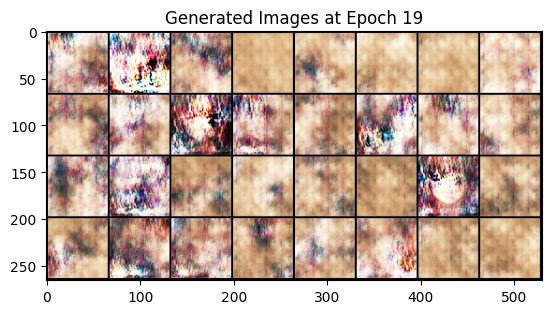

Epoch [20/25]  Loss D: -1.4595, loss G: 0.6857


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


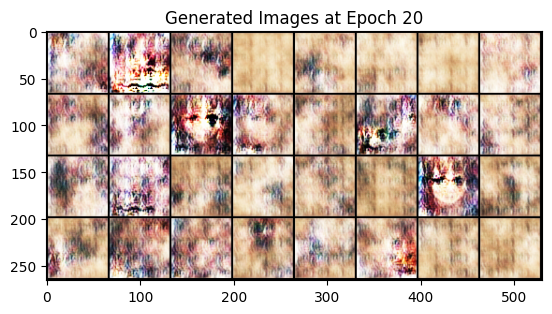

Epoch [21/25]  Loss D: -1.4526, loss G: 0.6820


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


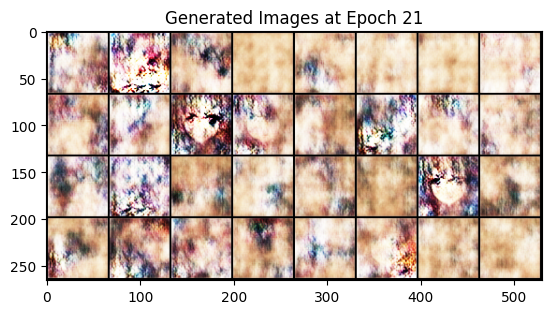

Epoch [22/25]  Loss D: -1.4556, loss G: 0.6841


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


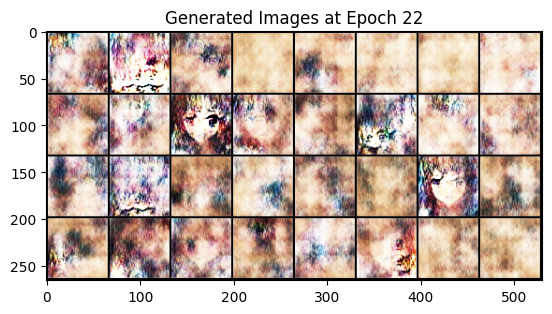

Epoch [23/25]  Loss D: -1.4421, loss G: 0.6801


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


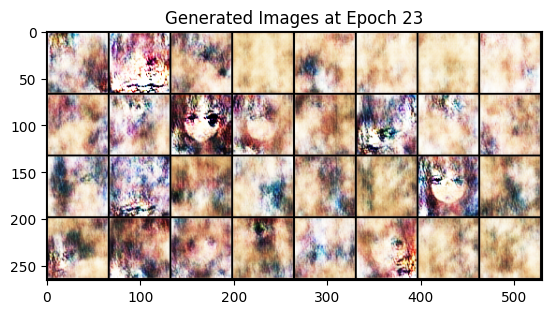

Epoch [24/25]  Loss D: -1.4514, loss G: 0.6828


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


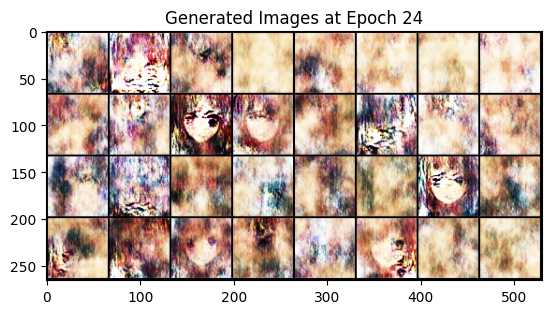

Epoch [25/25]  Loss D: -1.4399, loss G: 0.6771


In [16]:
gen_losses = []
critic_losses = []

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(tqdm(data_loader)):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            opt_critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        critic_losses.append(loss_critic.item())

        # Train Generator
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        gen_losses.append(loss_gen.item())

    plot_generated_images(gen, epoch, fixed_noise)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")

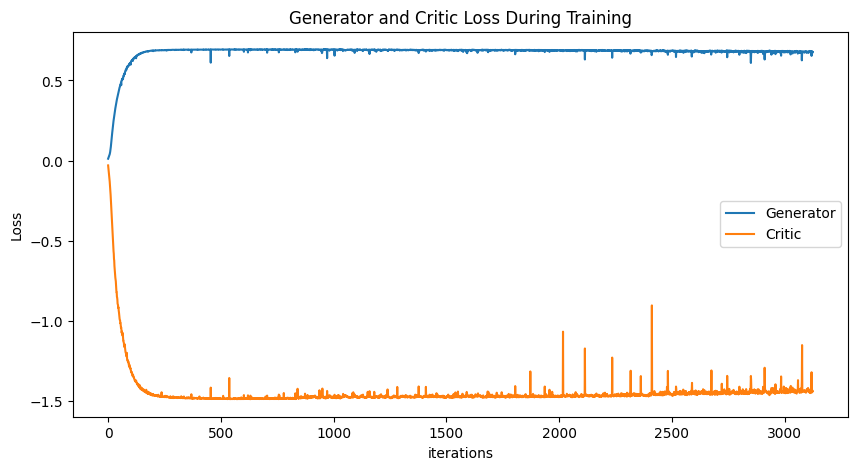

In [17]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Critic Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(critic_losses, label="Critic")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()